## Dependencias

In [1]:
from auxiliares import iv,woe,categorizar
from functools import reduce


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import warnings

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer


pd.set_option('display.max_columns', None)
sns.set_palette('colorblind')
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

## Análisis exploratorio de los datos

### Lectura de los datos 

In [2]:
datos = pd.read_csv('~/data_clean.csv')

In [3]:
df=datos.copy()

In [4]:
df.shape

(466285, 35)

### tipos de datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               466285 non-null  int64  
 1   loan_amnt                        466285 non-null  int64  
 2   funded_amnt                      466285 non-null  int64  
 3   funded_amnt_inv                  466285 non-null  float64
 4   term                             466285 non-null  int64  
 5   int_rate                         466285 non-null  float64
 6   installment                      466285 non-null  float64
 7   grade                            466285 non-null  object 
 8   sub_grade                        466285 non-null  object 
 9   emp_length                       445277 non-null  object 
 10  home_ownership                   466285 non-null  object 
 11  annual_inc                       466281 non-null  float64
 12  ve

### Definición de las variables

In [6]:
varc=['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc',
       'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal', 'total_rev_hi_lim', 
       'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog',
       'mths_between_issued_earliest_cr']

vard=['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'initial_list_status', 
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt']

um = ['id']

target=['target']

In [7]:
len(varc),len(vard)

(17, 16)

In [8]:
nulos=[*filter(lambda x: df[x].isna().mean()>0.3,vard+varc)] #variables con más del 30% de valores faltantes
varc=[var for var in varc if var not in nulos] #variables continuas menos del 30% de valores faltantes
vard=[var for var in vard if var not in nulos] #vvariables discretas menos del 30% de valores faltantes


In [9]:
len(varc),len(vard)

(14, 16)

### Análisis de las variables discretas

In [10]:
df[vard].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,delinq_2yrs,inq_last_6mths,pub_rec,initial_list_status,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt
0,36,B,B2,10+ years,RENT,Verified,n,credit_card,AZ,0.0,1.0,0.0,f,0.0,0.0,NaN
1,60,C,C4,< 1 year,RENT,Source Verified,n,car,GA,0.0,5.0,0.0,f,0.0,0.0,NaN
2,36,C,C5,10+ years,RENT,Not Verified,n,small_business,IL,0.0,2.0,0.0,f,0.0,0.0,NaN
3,36,C,C1,10+ years,RENT,Source Verified,n,other,CA,0.0,1.0,0.0,f,0.0,0.0,NaN
4,60,B,B5,1 year,RENT,Source Verified,n,other,OR,0.0,0.0,0.0,f,0.0,0.0,NaN


#### Valores faltantes

In [11]:
df[vard]=df[vard].astype('str').applymap(str.lower).astype('category')

#### Tabla de frequencias de las variables

In [12]:
for var in vard:
    print(var.center(50,'-'))
    print(df[var].value_counts(normalize=True,dropna=False))
    print('-'*50+'\n')

-----------------------term-----------------------
36    0.724778
60    0.275222
Name: term, dtype: float64
--------------------------------------------------

----------------------grade-----------------------
b    0.293659
c    0.268705
d    0.164895
a    0.160561
e    0.076685
f    0.028371
g    0.007124
Name: grade, dtype: float64
--------------------------------------------------

--------------------sub_grade---------------------
b3    0.067954
b4    0.065421
c1    0.057804
c2    0.057347
b2    0.057068
c3    0.054295
b5    0.054156
c4    0.051696
b1    0.049060
c5    0.047563
a5    0.046660
d1    0.041307
a4    0.040844
d2    0.036557
d3    0.031989
d4    0.030237
a3    0.026953
d5    0.024805
a2    0.023496
a1    0.022606
e1    0.019372
e2    0.018592
e3    0.014961
e4    0.012851
e5    0.010910
f1    0.008450
f2    0.006436
f3    0.005808
f4    0.004433
f5    0.003245
g1    0.002378
g2    0.001765
g3    0.001250
g4    0.000905
g5    0.000826
Name: sub_grade, dtype: float64
---

#### Categorización de variables (normalización)

In [13]:
df['purpose']=categorizar(df,'purpose',.05,'other')
df['delinq_2yrs']=categorizar(df,'delinq_2yrs',.05,'2+')
df['inq_last_6mths']=categorizar(df,'inq_last_6mths',.05,'4+')
df['pub_rec']=categorizar(df,'pub_rec',.05,'2+')
df['collections_12_mths_ex_med']=categorizar(df,'collections_12_mths_ex_med',.05,'1+')
df['acc_now_delinq']=categorizar(df,'acc_now_delinq',.05,'1+')
df['tot_coll_amt']=categorizar(df,'tot_coll_amt',.05,'1+')

In [14]:
for var in vard:
    print(var.center(50,'-'))
    print(df[var].value_counts(normalize=True))
    print('-'*50+'\n')

-----------------------term-----------------------
36    0.724778
60    0.275222
Name: term, dtype: float64
--------------------------------------------------

----------------------grade-----------------------
b    0.293659
c    0.268705
d    0.164895
a    0.160561
e    0.076685
f    0.028371
g    0.007124
Name: grade, dtype: float64
--------------------------------------------------

--------------------sub_grade---------------------
b3    0.067954
b4    0.065421
c1    0.057804
c2    0.057347
b2    0.057068
c3    0.054295
b5    0.054156
c4    0.051696
b1    0.049060
c5    0.047563
a5    0.046660
d1    0.041307
a4    0.040844
d2    0.036557
d3    0.031989
d4    0.030237
a3    0.026953
d5    0.024805
a2    0.023496
a1    0.022606
e1    0.019372
e2    0.018592
e3    0.014961
e4    0.012851
e5    0.010910
f1    0.008450
f2    0.006436
f3    0.005808
f4    0.004433
f5    0.003245
g1    0.002378
g2    0.001765
g3    0.001250
g4    0.000905
g5    0.000826
Name: sub_grade, dtype: float64
---

### Análisis de las variables continuas

#### Valores faltantes

In [15]:
im = SimpleImputer(strategy='median')
im.fit(df[varc])

SimpleImputer(strategy='median')

In [16]:
X_i=pd.DataFrame(im.transform(df[varc]),columns=varc) #imputamos valores faltantes con la mediana
X_i.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,mths_between_issued_earliest_cr
0,5000.0,5000.0,4975.0,10.65,162.87,24000.0,27.65,3.0,13648.0,83.7,9.0,81539.0,22800.0,327.0
1,2500.0,2500.0,2500.0,15.27,59.83,30000.0,1.00,3.0,1687.0,9.4,4.0,81539.0,22800.0,154.0
2,2400.0,2400.0,2400.0,15.96,84.33,12252.0,8.72,2.0,2956.0,98.5,10.0,81539.0,22800.0,122.0
3,10000.0,10000.0,10000.0,13.49,339.31,49200.0,20.00,10.0,5598.0,21.0,37.0,81539.0,22800.0,192.0
4,3000.0,3000.0,3000.0,12.69,67.79,80000.0,17.94,15.0,27783.0,53.9,38.0,81539.0,22800.0,193.0


In [17]:
#calculamos estadistico ks
ks=pd.DataFrame(map(lambda x: (x,round(stats.ks_2samp(X_i[x],df[x].dropna()).statistic,3)),varc),columns=['variable','ks']) 
ks #el estadistico ks es pequeño, por lo la imputacion no afecto la distribucion de las variables

,variable,ks
0,loan_amnt,0.000
1,funded_amnt,0.000
2,funded_amnt_inv,0.000
3,int_rate,0.000
4,installment,0.000
5,annual_inc,0.000
6,dti,0.000
7,open_acc,0.000
8,revol_bal,0.000
9,revol_util,0.000


#### Discretización de variables

In [18]:
vars_disc=[]
for bin in range(30,71,10):    
    bins=bin
    kb=KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy='quantile')
    aux=pd.DataFrame(kb.fit_transform(X_i[varc]),columns=[f'{var}_{bins}' for var in varc])
    mapa={var:{k:v for k,v in enumerate(vals)} for var,vals in \
          zip(aux.columns,map(lambda x:[*map(lambda x:str(x).replace(')',']'),zip(x,x[1:]))],kb.bin_edges_))}
    vars_disc.append(aux)

In [19]:
X_disc=pd.concat(vars_disc,axis=1)
X_disc.head()

,loan_amnt_30,funded_amnt_30,funded_amnt_inv_30,int_rate_30,installment_30,annual_inc_30,dti_30,open_acc_30,revol_bal_30,revol_util_30,total_acc_30,tot_cur_bal_30,total_rev_hi_lim_30,mths_between_issued_earliest_cr_30,loan_amnt_40,funded_amnt_40,funded_amnt_inv_40,int_rate_40,installment_40,annual_inc_40,dti_40,open_acc_40,revol_bal_40,revol_util_40,total_acc_40,tot_cur_bal_40,total_rev_hi_lim_40,mths_between_issued_earliest_cr_40,loan_amnt_50,funded_amnt_50,funded_amnt_inv_50,int_rate_50,installment_50,annual_inc_50,dti_50,open_acc_50,revol_bal_50,revol_util_50,total_acc_50,tot_cur_bal_50,total_rev_hi_lim_50,mths_between_issued_earliest_cr_50,loan_amnt_60,funded_amnt_60,funded_amnt_inv_60,int_rate_60,installment_60,annual_inc_60,dti_60,open_acc_60,revol_bal_60,revol_util_60,total_acc_60,tot_cur_bal_60,total_rev_hi_lim_60,mths_between_issued_earliest_cr_60,loan_amnt_70,funded_amnt_70,funded_amnt_inv_70,int_rate_70,installment_70,annual_inc_70,dti_70,open_acc_70,revol_bal_70,revol_util_70,total_acc_70,tot_cur_bal_70,total_rev_hi_lim_70,mths_between_issued_earliest_cr_70
0,3.0,3.0,2.0,7.0,2.0,0.0,26.0,0.0,17.0,25.0,1.0,13.0,13.0,27.0,4.0,4.0,3.0,9.0,3.0,1.0,35.0,0.0,22.0,34.0,2.0,17.0,17.0,36.0,5.0,5.0,4.0,11.0,4.0,1.0,44.0,0.0,28.0,43.0,2.0,22.0,22.0,45.0,6.0,6.0,5.0,14.0,5.0,1.0,53.0,0.0,34.0,51.0,3.0,26.0,26.0,54.0,7.0,7.0,6.0,14.0,6.0,2.0,62.0,1.0,39.0,60.0,3.0,30.0,30.0,64.0
1,0.0,0.0,0.0,19.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,13.0,13.0,11.0,1.0,1.0,1.0,24.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,17.0,17.0,14.0,1.0,1.0,1.0,30.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,22.0,22.0,18.0,1.0,1.0,1.0,33.0,0.0,4.0,0.0,0.0,2.0,1.0,0.0,26.0,26.0,22.0,1.0,1.0,2.0,37.0,0.0,5.0,0.0,1.0,2.0,2.0,0.0,30.0,30.0,25.0
2,0.0,0.0,0.0,21.0,0.0,0.0,4.0,0.0,2.0,29.0,2.0,13.0,13.0,5.0,0.0,0.0,1.0,27.0,1.0,0.0,6.0,0.0,3.0,39.0,3.0,17.0,17.0,7.0,1.0,1.0,1.0,33.0,1.0,0.0,7.0,0.0,4.0,49.0,3.0,22.0,22.0,9.0,1.0,1.0,1.0,37.0,1.0,0.0,9.0,0.0,4.0,59.0,4.0,26.0,26.0,11.0,1.0,1.0,1.0,40.0,1.0,0.0,10.0,0.0,5.0,69.0,4.0,30.0,30.0,13.0
3,10.0,10.0,11.0,14.0,12.0,9.0,19.0,7.0,6.0,2.0,24.0,13.0,13.0,17.0,14.0,14.0,12.0,18.0,16.0,12.0,25.0,7.0,8.0,3.0,28.0,17.0,17.0,23.0,15.0,15.0,17.0,22.0,21.0,14.0,32.0,7.0,10.0,4.0,29.0,22.0,22.0,29.0,17.0,17.0,18.0,25.0,25.0,17.0,38.0,7.0,12.0,5.0,31.0,26.0,26.0,34.0,19.0,20.0,20.0,27.0,29.0,19.0,44.0,8.0,14.0,6.0,31.0,30.0,30.0,40.0
4,1.0,1.0,1.0,12.0,0.0,20.0,16.0,12.0,25.0,13.0,25.0,13.0,13.0,17.0,1.0,1.0,1.0,15.0,0.0,26.0,21.0,12.0,34.0,17.0,28.0,17.0,17.0,23.0,2.0,2.0,2.0,19.0,0.0,31.0,27.0,12.0,43.0,22.0,30.0,22.0,22.0,29.0,2.0,2.0,2.0,21.0,0.0,36.0,32.0,12.0,51.0,26.0,32.0,26.0,26.0,35.0,3.0,3.0,3.0,23.0,1.0,39.0,38.0,13.0,60.0,31.0,32.0,30.0,30.0,41.0


## Particionamos la muestra en train y test

In [20]:
muestra=pd.concat([df[um],df[vard],X_disc,df[target]],axis=1)
train,test=train_test_split(muestra,test_size=.3,stratify=muestra['target'],random_state=11238)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
train.shape,test.shape

((326399, 88), (139886, 88))

## Transformación WoE datos de entrenamiento

In [21]:
mapa={var:woe(train,var,'target')['woe'].to_dict() for var in train.columns if var not in um+target}

In [22]:
train_woe=train.replace(mapa)
train_woe.head()

,id,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,delinq_2yrs,inq_last_6mths,pub_rec,initial_list_status,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,loan_amnt_30,funded_amnt_30,funded_amnt_inv_30,int_rate_30,installment_30,annual_inc_30,dti_30,open_acc_30,revol_bal_30,revol_util_30,total_acc_30,tot_cur_bal_30,total_rev_hi_lim_30,mths_between_issued_earliest_cr_30,loan_amnt_40,funded_amnt_40,funded_amnt_inv_40,int_rate_40,installment_40,annual_inc_40,dti_40,open_acc_40,revol_bal_40,revol_util_40,total_acc_40,tot_cur_bal_40,total_rev_hi_lim_40,mths_between_issued_earliest_cr_40,loan_amnt_50,funded_amnt_50,funded_amnt_inv_50,int_rate_50,installment_50,annual_inc_50,dti_50,open_acc_50,revol_bal_50,revol_util_50,total_acc_50,tot_cur_bal_50,total_rev_hi_lim_50,mths_between_issued_earliest_cr_50,loan_amnt_60,funded_amnt_60,funded_amnt_inv_60,int_rate_60,installment_60,annual_inc_60,dti_60,open_acc_60,revol_bal_60,revol_util_60,total_acc_60,tot_cur_bal_60,total_rev_hi_lim_60,mths_between_issued_earliest_cr_60,loan_amnt_70,funded_amnt_70,funded_amnt_inv_70,int_rate_70,installment_70,annual_inc_70,dti_70,open_acc_70,revol_bal_70,revol_util_70,total_acc_70,tot_cur_bal_70,total_rev_hi_lim_70,mths_between_issued_earliest_cr_70,target
0,1152009,0.135979,1.115631,0.991728,-0.033138,0.140725,-0.171171,0.000042,-0.233508,0.152194,0.001413,-0.442271,-0.011207,-0.106289,-0.00106,-0.000285,-0.390264,-0.075114,-0.075307,-0.079571,0.919455,-0.150876,0.246596,0.219360,-0.017199,-0.002180,0.337972,0.009824,-0.337226,-0.339335,0.050943,0.007690,0.033641,-0.200382,0.839204,-0.075794,0.251718,0.214977,-0.017199,-0.008745,0.378668,0.009824,-0.337226,-0.339335,0.078708,0.031185,0.033641,-0.200382,0.839204,-0.144533,0.252671,0.217412,-0.017199,-0.051211,0.432017,0.009824,-0.378761,-0.378706,-0.007408,0.031185,0.033641,-0.200382,0.739219,-0.042079,0.249623,0.211305,-0.017199,0.004140,0.319820,0.009824,-0.371314,-0.373481,0.029047,0.127084,0.131175,-0.200382,0.839204,-0.027136,0.250220,0.232296,-0.017199,0.042236,0.381552,0.009824,-0.366629,-0.369722,0.021175,0
1,19937859,0.135979,0.372679,0.687541,-0.017529,-0.001913,0.161334,0.000042,-0.233508,-0.031987,0.001413,-0.061641,-0.011207,0.224335,-0.00106,-0.000285,0.079100,-0.054342,-0.103135,-0.109925,0.879665,-0.045067,0.308527,0.064958,-0.027277,-0.013949,-0.154859,0.071774,0.175227,0.036560,0.027885,-0.087629,-0.090654,-0.086850,0.840073,-0.049965,0.261887,0.083101,-0.027277,-0.003814,-0.080132,0.051135,0.208002,0.062022,0.019410,0.010872,-0.047617,-0.091872,0.835978,-0.073893,0.251991,0.118993,-0.027277,0.006781,-0.097593,0.051135,0.206435,-0.006694,-0.010173,-0.052874,-0.047332,-0.068585,1.144430,-0.097644,0.261887,0.086491,-0.027277,-0.008144,-0.108435,0.051135,0.221927,0.017987,0.005970,-0.076439,-0.074800,-0.084823,1.144430,-0.118472,0.255810,0.049713,-0.027277,0.026323,-0.070900,0.051135,0.245301,-0.006789,0.005970,0
2,11964802,0.135979,1.115631,0.991728,-0.033138,0.140725,0.056090,0.000042,0.257785,0.152194,0.001413,-0.532562,-0.011207,-0.106289,-0.00106,-0.000285,0.079100,-0.039113,-0.042040,-0.031055,0.919455,-0.108238,0.119129,0.219360,-0.014273,-0.073641,0.308058,-0.065703,0.229046,0.268522,0.222138,-0.032780,0.018688,0.005497,0.839204,-0.082169,0.114433,0.214977,-0.014273,-0.075608,0.347197,-0.065703,0.237277,0.259726,0.214177,-0.004273,-0.002031,0.005497,0.839204,-0.071949,0.126203,0.217412,-0.014273,-0.023921,0.366867,-0.065703,0.233142,0.236668,0.263960,-0.004273,-0.002031,-0.001944,0.739219,-0.056015,0.102045,0.211305,-0.014273,-0.092466,0.374158,-0.065703,0.238886,0.241265,0.255186,-0.004273,0.009491,0.036856,0.839204,-0.079399,0.090283,0.232296,-0.014273,-0.080982,0.365322,-0.065703,0.209237,0.220096,0.230755,0
3,32329356,0.135979,0.372679,0.147639,-0.071490,-0.155808,0.056090,0.000042,-0.040423,0.155442,0.001413,-0.061641,-0.011207,-0.106289,-0.00106,-0.000285,0.079100,0.049477,0.030981,-0.037887,0.332877,0.017456,-0.062862,-0.

In [23]:
df_iv=pd.Series({var:iv(train,var,'target') for var in train.columns if var not in um+target})\
.sort_values(ascending=False).reset_index().rename(columns={'index':'variable',0:'iv'})

In [24]:
best=['int_rate_70','sub_grade','grade','tot_cur_bal_50','total_rev_hi_lim_60'
      ,'annual_inc_70','inq_last_6mths','term']

In [25]:
df_iv[df_iv.iv>.04]

,variable,iv
0,addr_state,inf
1,int_rate_70,0.365001
2,int_rate_60,0.363197
3,int_rate_50,0.361841
4,int_rate_40,0.352049
5,int_rate_30,0.341591
6,sub_grade,0.319020
7,grade,0.294424
8,tot_cur_bal_50,0.062812
9,tot_cur_bal_70,0.062794


In [26]:
X_train=train_woe[best]
y_train=train_woe[target]

## Entrenamiento del modelo (Regresión Logística)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,classification_report
from scikitplot.metrics import plot_roc,plot_ks_statistic

In [42]:
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [49]:
confusion_matrix(y_train,lr.predict(X_train))

array([[172260, 118461],
       [ 11434,  24244]])

In [44]:
(confusion_matrix(y_train,lr.predict(X_train))/len(y_train))

array([[0.52775897, 0.3629331 ],
       [0.03503074, 0.07427719]])

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

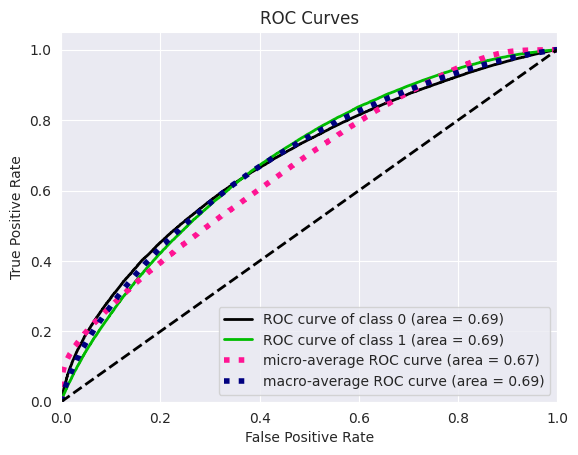

In [45]:
plot_roc(y_train,lr.predict_proba(X_train))

In [46]:
roc_auc_score(y_train,lr.predict_proba(X_train)[:,1])

0.6856241901609819

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

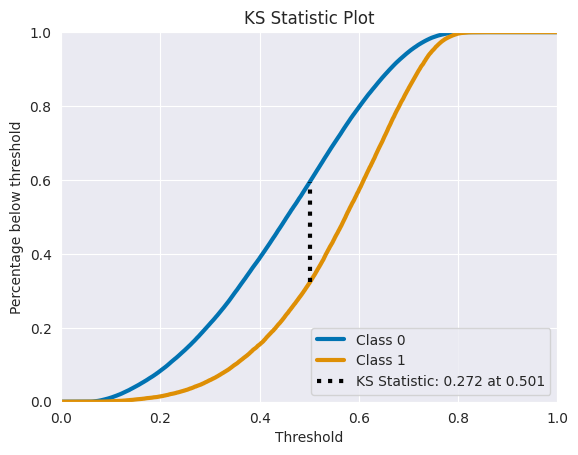

In [66]:
plot_ks_statistic(y_train,lr.predict_proba(X_train))

## Evaluación del modelo 

In [56]:
test_woe=test.replace(mapa)
test_woe.head()

,id,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,delinq_2yrs,inq_last_6mths,pub_rec,initial_list_status,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,loan_amnt_30,funded_amnt_30,funded_amnt_inv_30,int_rate_30,installment_30,annual_inc_30,dti_30,open_acc_30,revol_bal_30,revol_util_30,total_acc_30,tot_cur_bal_30,total_rev_hi_lim_30,mths_between_issued_earliest_cr_30,loan_amnt_40,funded_amnt_40,funded_amnt_inv_40,int_rate_40,installment_40,annual_inc_40,dti_40,open_acc_40,revol_bal_40,revol_util_40,total_acc_40,tot_cur_bal_40,total_rev_hi_lim_40,mths_between_issued_earliest_cr_40,loan_amnt_50,funded_amnt_50,funded_amnt_inv_50,int_rate_50,installment_50,annual_inc_50,dti_50,open_acc_50,revol_bal_50,revol_util_50,total_acc_50,tot_cur_bal_50,total_rev_hi_lim_50,mths_between_issued_earliest_cr_50,loan_amnt_60,funded_amnt_60,funded_amnt_inv_60,int_rate_60,installment_60,annual_inc_60,dti_60,open_acc_60,revol_bal_60,revol_util_60,total_acc_60,tot_cur_bal_60,total_rev_hi_lim_60,mths_between_issued_earliest_cr_60,loan_amnt_70,funded_amnt_70,funded_amnt_inv_70,int_rate_70,installment_70,annual_inc_70,dti_70,open_acc_70,revol_bal_70,revol_util_70,total_acc_70,tot_cur_bal_70,total_rev_hi_lim_70,mths_between_issued_earliest_cr_70,target
0,643778,0.135979,1.115631,0.835861,0.098824,0.140725,0.056090,0.000042,-0.040423,-0.160712,0.020762,-0.061641,-0.011207,-0.106289,-0.00106,-0.000285,-0.390264,0.069925,0.075756,0.005743,1.424431,0.092426,0.071608,0.114155,-0.009536,-0.026908,0.337972,0.079038,-0.337226,-0.339335,0.222138,0.069925,0.075756,-0.147581,1.401948,0.009826,0.071608,0.102128,-0.009536,-0.045382,0.378668,0.079038,-0.337226,-0.339335,0.214177,0.069925,0.075756,-0.101002,1.429162,0.190061,0.071608,0.115192,-0.009536,-0.024709,0.315745,0.079038,-0.378761,-0.378706,0.263960,0.069925,0.075756,-0.141584,1.401948,0.119526,0.071608,0.127245,-0.009536,-0.026825,0.319820,0.079038,-0.371314,-0.373481,0.255186,0.069925,0.075756,-0.128522,1.311090,0.135444,0.071608,0.126018,-0.009536,0.006400,0.334887,0.079038,-0.366629,-0.369722,0.230755,0
1,6166968,0.135979,0.372679,0.687541,0.098824,0.140725,0.161334,0.000042,-0.040423,-0.004748,0.020762,-0.247871,-0.011207,-0.106289,-0.00106,-0.000285,0.079100,0.069925,0.075756,-0.096267,0.879665,0.135831,0.308527,-0.036496,-0.017199,-0.020846,-0.063914,0.071616,0.118807,0.025847,0.222138,0.069925,0.075756,-0.092912,0.706127,0.079310,0.351389,-0.019348,-0.017199,-0.008651,-0.109868,0.023801,0.208002,0.066241,0.238249,0.069925,0.075756,-0.112389,0.700382,0.132591,0.355010,-0.020465,-0.017199,-0.031498,-0.042766,0.023801,0.206435,0.083753,0.201568,0.069925,0.075756,-0.096267,0.649145,0.172158,0.401982,-0.065229,-0.017199,-0.031623,-0.058288,0.023801,0.164497,0.038540,0.188787,0.069925,0.075756,-0.178888,0.649145,0.058437,0.394368,-0.016429,-0.017199,-0.008343,-0.036663,0.023801,0.245301,0.071671,0.196803,0
2,20069833,0.135979,-0.396854,-0.480962,-0.033138,-0.155808,0.056090,0.000042,-0.040423,-0.057502,0.020762,0.200925,-0.011207,0.224335,-0.00106,-0.000285,0.079100,-0.144690,-0.157429,-0.139237,-0.429078,0.138022,-0.174218,-0.047882,-0.027277,0.031771,0.050162,-0.011463,0.017054,0.288512,0.096314,-0.099878,-0.109152,-0.136636,-0.264753,0.107271,-0.174218,-0.076261,-0.027277,0.028060,0.049413,-0.011463,0.026262,0.285440,0.060783,-0.234176,-0.272477,-0.131906,-0.264753,0.132894,-0.174218,0.014745,-0.027277,0.078094,0.061827,-0.011463,0.023683,0.267534,0.055560,-0.194202,-0.205305,-0.226666,-0.226416,0.176315,-0.174218,-0.070472,-0.027277,0.132082,0.043261,-0.011463,0.038157,0.267552,0.054009,-0.212498,-0.197884,-0.215358,-0.404985,0.183840,-0.174218,-0.014333,-0.027277,0.131228,0.048503,-0.011463,0.094676,0.267426,0.066896,0
3,8565675,-0.302039,-0.396854,-0.380701,0.098824,0.140725,-0.171171,0.000042,-0.040423,-0.048746,0.001413,0.200925,-0.011207,-0.106289,-0.00106,-0.000285,0.079100,-0.284970,-0.288428,-0.037887,-0.534459,0.006159,0.246596,0.129922,-

In [57]:
X_test=test_woe[best]
y_test=test_woe[target]

In [61]:
confusion_matrix(y_test,lr.predict(X_test))

array([[73913, 50683],
       [ 5022, 10268]])

In [62]:
confusion_matrix(y_test,lr.predict(X_test))/len(y_test)

array([[0.52838025, 0.36231646],
       [0.03590066, 0.07340263]])

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

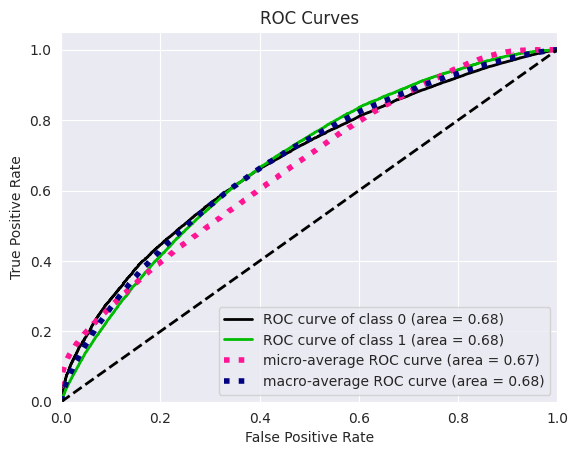

In [64]:
plot_roc(y_test,lr.predict_proba(X_test))

In [68]:
roc_auc_score(y_test,lr.predict_proba(X_test)[:,1])

0.6816237246865584

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

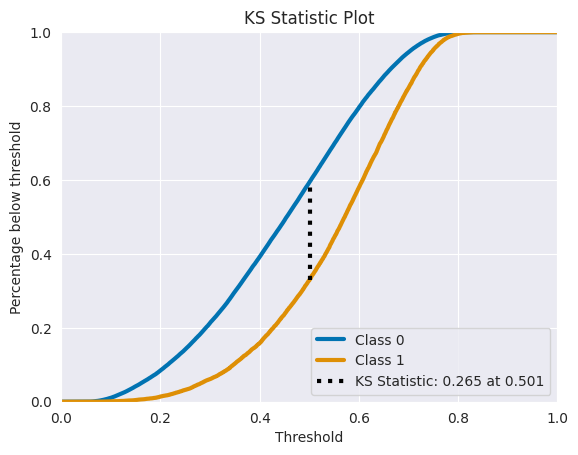

In [70]:
plot_ks_statistic(y_test,lr.predict_proba(X_test))